# Mounting Google Drive to access Dataset

In [1]:
# Mount Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Converting Pascal VOC Format of Dataset to YOLO Format
# **Pascal VOC** : $(x_{min}, y_{min}, x_{max},y_{max})$
# **YOLO** : $(x_{center-norm},y_{center-norm}, w_{norm}, h_{norm})$
# $x_{norm}$ = $\frac{x}{widthofWholeImage}$
# $y_{norm}$ = $\frac{y}{heightofWholeImage}$
# $w_{norm}$ = $\frac{w}{widthofWholeImage}$
# $h_{norm}$ = $\frac{h}{heightofWholeImage}$



In [2]:
from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import numpy as np
import pandas as pd

In [3]:
classes = ['helmet','head','person']

def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [4]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/content/drive/My Drive/helmet_dataset_YOLO/labels/' +  img_jpg_file_name + '.txt'

    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [5]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'

    tree = ET.parse(img_path)
    root = tree.getroot()

    img_name = root.find("filename").text
    img_size = root.find("size")
    img_w = int(img_size.find("width").text)
    img_h = int(img_size.find("height").text)
    img_c = int(img_size.find("depth").text)

    img_box = []
    for box in root.findall("object"):
        cls_name = box.find("name").text
        x1 = int(box.find("bndbox").find("xmin").text)
        y1 = int(box.find("bndbox").find("ymin").text)
        x2 = int(box.find("bndbox").find("xmax").text)
        y2 = int(box.find("bndbox").find("ymax").text)

        img_box.append([cls_name, x1, y1, x2, y2])

    img_jpg_file_name = img_xml_file + '.jpg'
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [7]:
import os
files= os.listdir('/content/drive/MyDrive/helmet_dataset_YOLO/images')
print(len(files))

5000


In [8]:
from tqdm import tqdm
os.makedirs('/content/drive/My Drive/helmet_dataset_YOLO/labels',exist_ok = True)

files = os.listdir('/content/drive/My Drive/helmet_dataset_YOLO/annotations')
for file in tqdm(files, total=len(files)):
    file_xml = file.split(".")
    get_xml_data('/content/drive/My Drive/helmet_dataset_YOLO/annotations', file_xml[0])

100%|██████████| 5000/5000 [03:00<00:00, 27.67it/s]


# Dataset Split : 80% Train, 10% Val & 10% Test.

In [9]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/content/drive/My Drive/helmet_dataset_YOLO/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =', len(image_list))
print('train :', len(train_list))
print('val   :', len(val_list))
print('test  :', len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [10]:
from pathlib import Path
from shutil import copyfile
from tqdm import tqdm

def copy_data(file_list, img_labels_root, imgs_source, mode):
    dataset_root = Path('/content/drive/My Drive/helmet_dataset_YOLO')

    # Create directories if they don't exist
    images_path = dataset_root / 'images' / mode
    labels_path = dataset_root / 'labels' / mode
    images_path.mkdir(parents=True, exist_ok=True)
    labels_path.mkdir(parents=True, exist_ok=True)

    # Copying files with progress bar
    for file in tqdm(file_list, desc=f"Copying {mode} data"):
        base_filename = file.replace('.png', '')

        img_src_file = Path(imgs_source) / (base_filename + '.png')
        label_src_file = Path(img_labels_root) / (base_filename + '.txt')

        img_dest_file = images_path / (base_filename + '.png')
        label_dest_file = labels_path / (base_filename + '.txt')

        copyfile(img_src_file, img_dest_file)
        copyfile(label_src_file, label_dest_file)

# Example usage
copy_data(train_list, '/content/drive/My Drive/helmet_dataset_YOLO/labels', '/content/drive/My Drive/helmet_dataset_YOLO/images', "train")
copy_data(val_list,   '/content/drive/My Drive/helmet_dataset_YOLO/labels', '/content/drive/My Drive/helmet_dataset_YOLO/images', "val")
copy_data(test_list,  '/content/drive/My Drive/helmet_dataset_YOLO/labels', '/content/drive/My Drive/helmet_dataset_YOLO/images', "test")

Copying test data: 100%|██████████| 500/500 [00:11<00:00, 45.45it/s]


#Installing Ultralytics Package

In [11]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 21679, done.
remote: Counting objects: 100% (748/748), done.
remote: Compressing objects: 100% (495/495), done.
remote: Total 21679 (delta 450), reused 462 (delta 252), pack-reused 20931
Receiving objects: 100% (21679/21679), 13.12 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (14965/14965), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 kB 15.4 MB/s eta 0:00:00


 # Configuring the .yaml File
 # YOLO locates **labels** automatically for each image by replacing the instance of **/images/** in each image path with **/labels/**.

In [13]:
# For example:

# "/content/drive/My Drive/helmet_dataset_YOLO/images/train/hard_hat_workers0.png"  # image
# "/content/drive/My Drive/helmet_dataset_YOLO/labels/train/hard_hat_workers0.txt  # label

import yaml

# Create configuration
config = {

   "train": "/content/drive/My Drive/helmet_dataset_YOLO/images/train",
   "val": "/content/drive/My Drive/helmet_dataset_YOLO/images/val",
   "test": "/content/drive/My Drive/helmet_dataset_YOLO/images/test",
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [14]:
!cat data.yaml

names:
- helmet
- head
- person
nc: 3
test: /content/drive/My Drive/helmet_dataset_YOLO/images/test
train: /content/drive/My Drive/helmet_dataset_YOLO/images/train
val: /content/drive/My Drive/helmet_dataset_YOLO/images/val


# **Training the Model**
# Here, we are using the medium version of pre-trained YOLOv8 Model (**yolov8m.pt**)
# In whole code, we are mostly using the CLI commands.
#(you can use pythonoic version too).

# **Training Hyperparameters**

1.   **Epoch = 20**
2.   **Batch Size = 16**
3.   **Workers = 8 (number of worker threads for data loading)**
4.   **Initital Learning Rate ($η_i$) [lr0] = 0.01**
5.   **Final Learning Rate ($η_f$) [lr0 * lrf] = 0.01 * 0.01 = 0.0001**
6.   **Optimizer is set to auto, choices=[SGD, Adam, Adamax, AdamW, NAdam,
     RAdam, RMSProp, auto]**
7.   **Momentum (β)	= 0.937	(SGD momentum / Adam ($β_1$) )**
8.   **Weight Decay (λ) = 0.0005**
9.   **Linear LR Scheduler which deacys η every epoch linearly from ($η_i$) to ($η_f$) at the last epoch of training.**

**All hyperparamaters & configurations including the above are used with their (default values) except for number of epochs whose default value is 100.**

# ***Tips for best Training Results***

Most of the time good results can be obtained with no changes to the models or training settings.If at first you don't get good results, there are steps you might be able to take to improve.


1. **Epochs** : Start with 300 epochs. If this overfits early then you can reduce epochs. If overfitting does not occur after 300 epochs, train longer, i.e. 600, 1200 etc. epochs.

2. **Image size** : COCO trains at native resolution of --img 640, though due to the high amount of small objects in the dataset it can benefit from training at higher resolutions such as --img 1280. If there are many small objects then custom datasets will benefit from training at native or higher resolution. Best inference results are obtained at the same --img as the training was run at, i.e. if you train at --img 1280 you should also test and detect at --img 1280.

3. **Batch size** : Use the largest batch size that your hardware allows for. Small batch sizes produce poor batchnorm statistics and should be avoided.


# ***Hyperparamter Tuning***

**Ultralytics YOLO uses genetic algorithms to optimize hyperparameters. Genetic algorithms are inspired by the mechanism of natural selection and genetics.**

**Mutation** : In the context of Ultralytics YOLO, mutation helps in locally searching the hyperparameter space by applying small, random changes to existing hyperparameters, producing new candidates for evaluation.

**Crossover** : Although crossover is a popular genetic algorithm technique, it is not currently used in Ultralytics YOLO for hyperparameter tuning. The focus is mainly on mutation for generating new hyperparameter sets.

In [15]:
!yolo task=detect mode=train data=data.yaml model=yolov8m.pt epochs=20 lr0=0.01

100% 49.7M/49.7M [00:00<00:00, 299MB/s]
Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

In [ ]:
import shutil
# Define paths
source_dir = '/content/runs/detect/train'
destination_dir = '/content/drive/My Drive/helmet_dataset_YOLO/YOLO_results'
os.makedirs(destination_dir,exist_ok = True)

# Copy files from runs/detect to Google Drive
shutil.copytree(source_dir, os.path.join(destination_dir,'train'))

In [ ]:
import shutil
src_path= '/content/runs/detect/train/weights/best.pt'
dst_path= '/content/drive/MyDrive/helmet_dataset_YOLO'
shutil.copy(src_path, dst_path)

# Analysis & Visualization of Predictions

In [ ]:
!ls /content/runs/detect/train

In [23]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

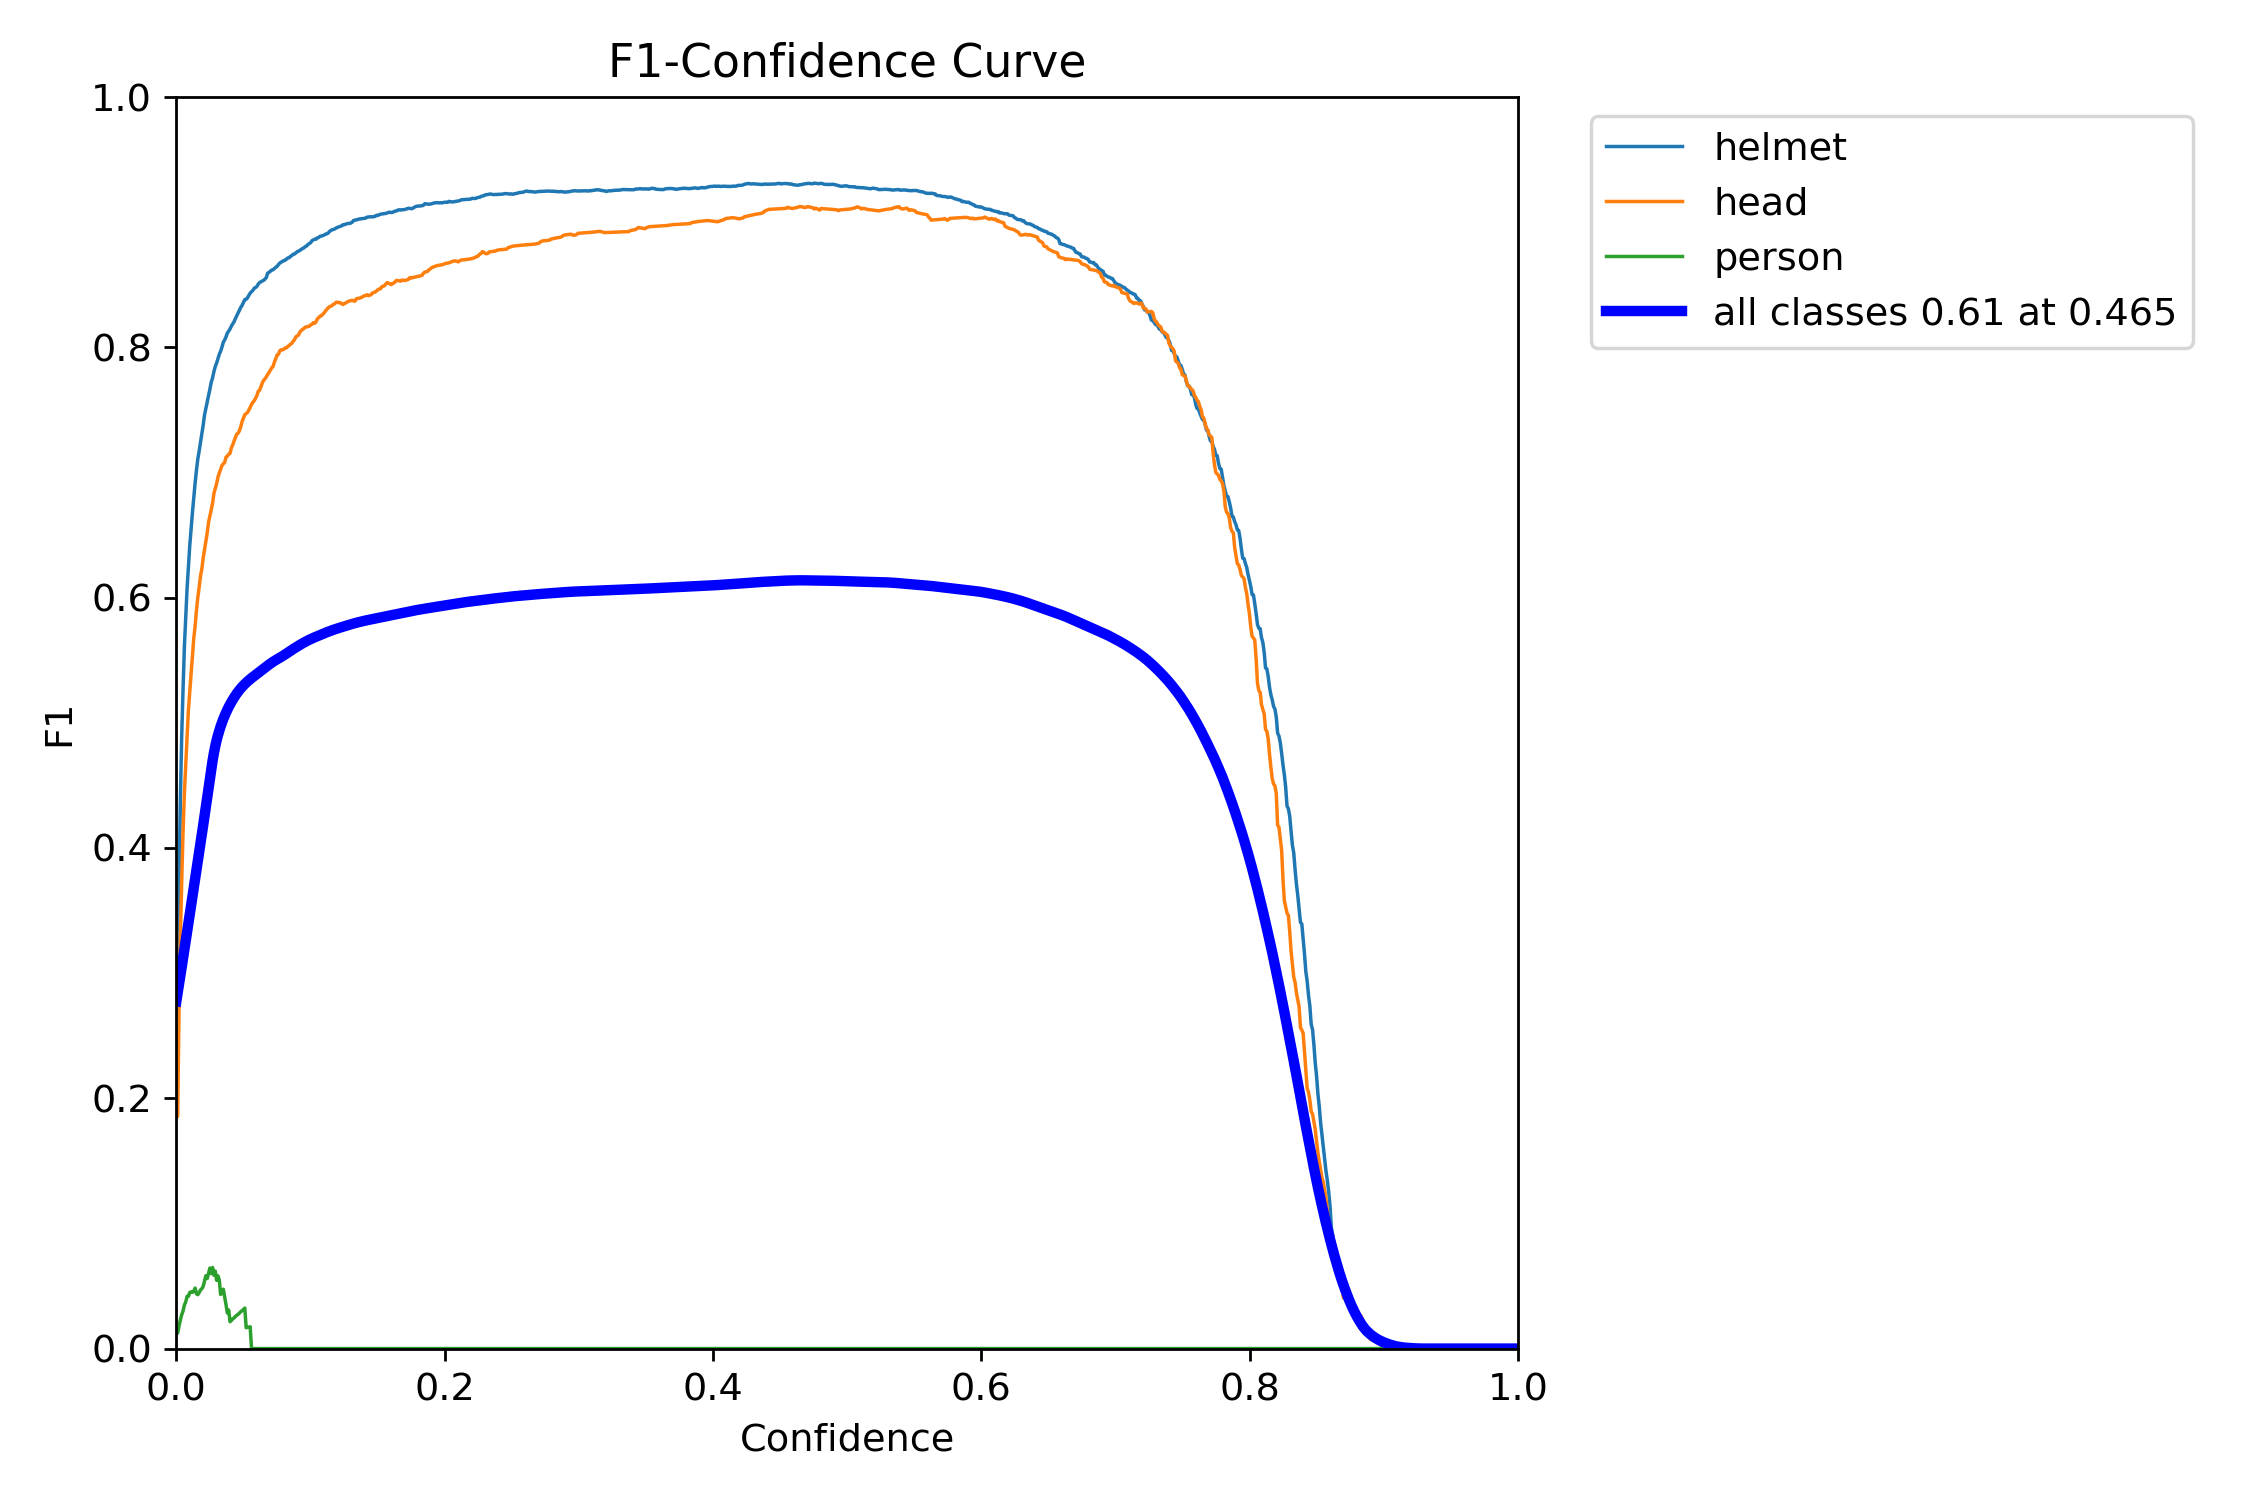

In [24]:
Image(filename='/content/runs/detect/train/F1_curve.png', width=600)

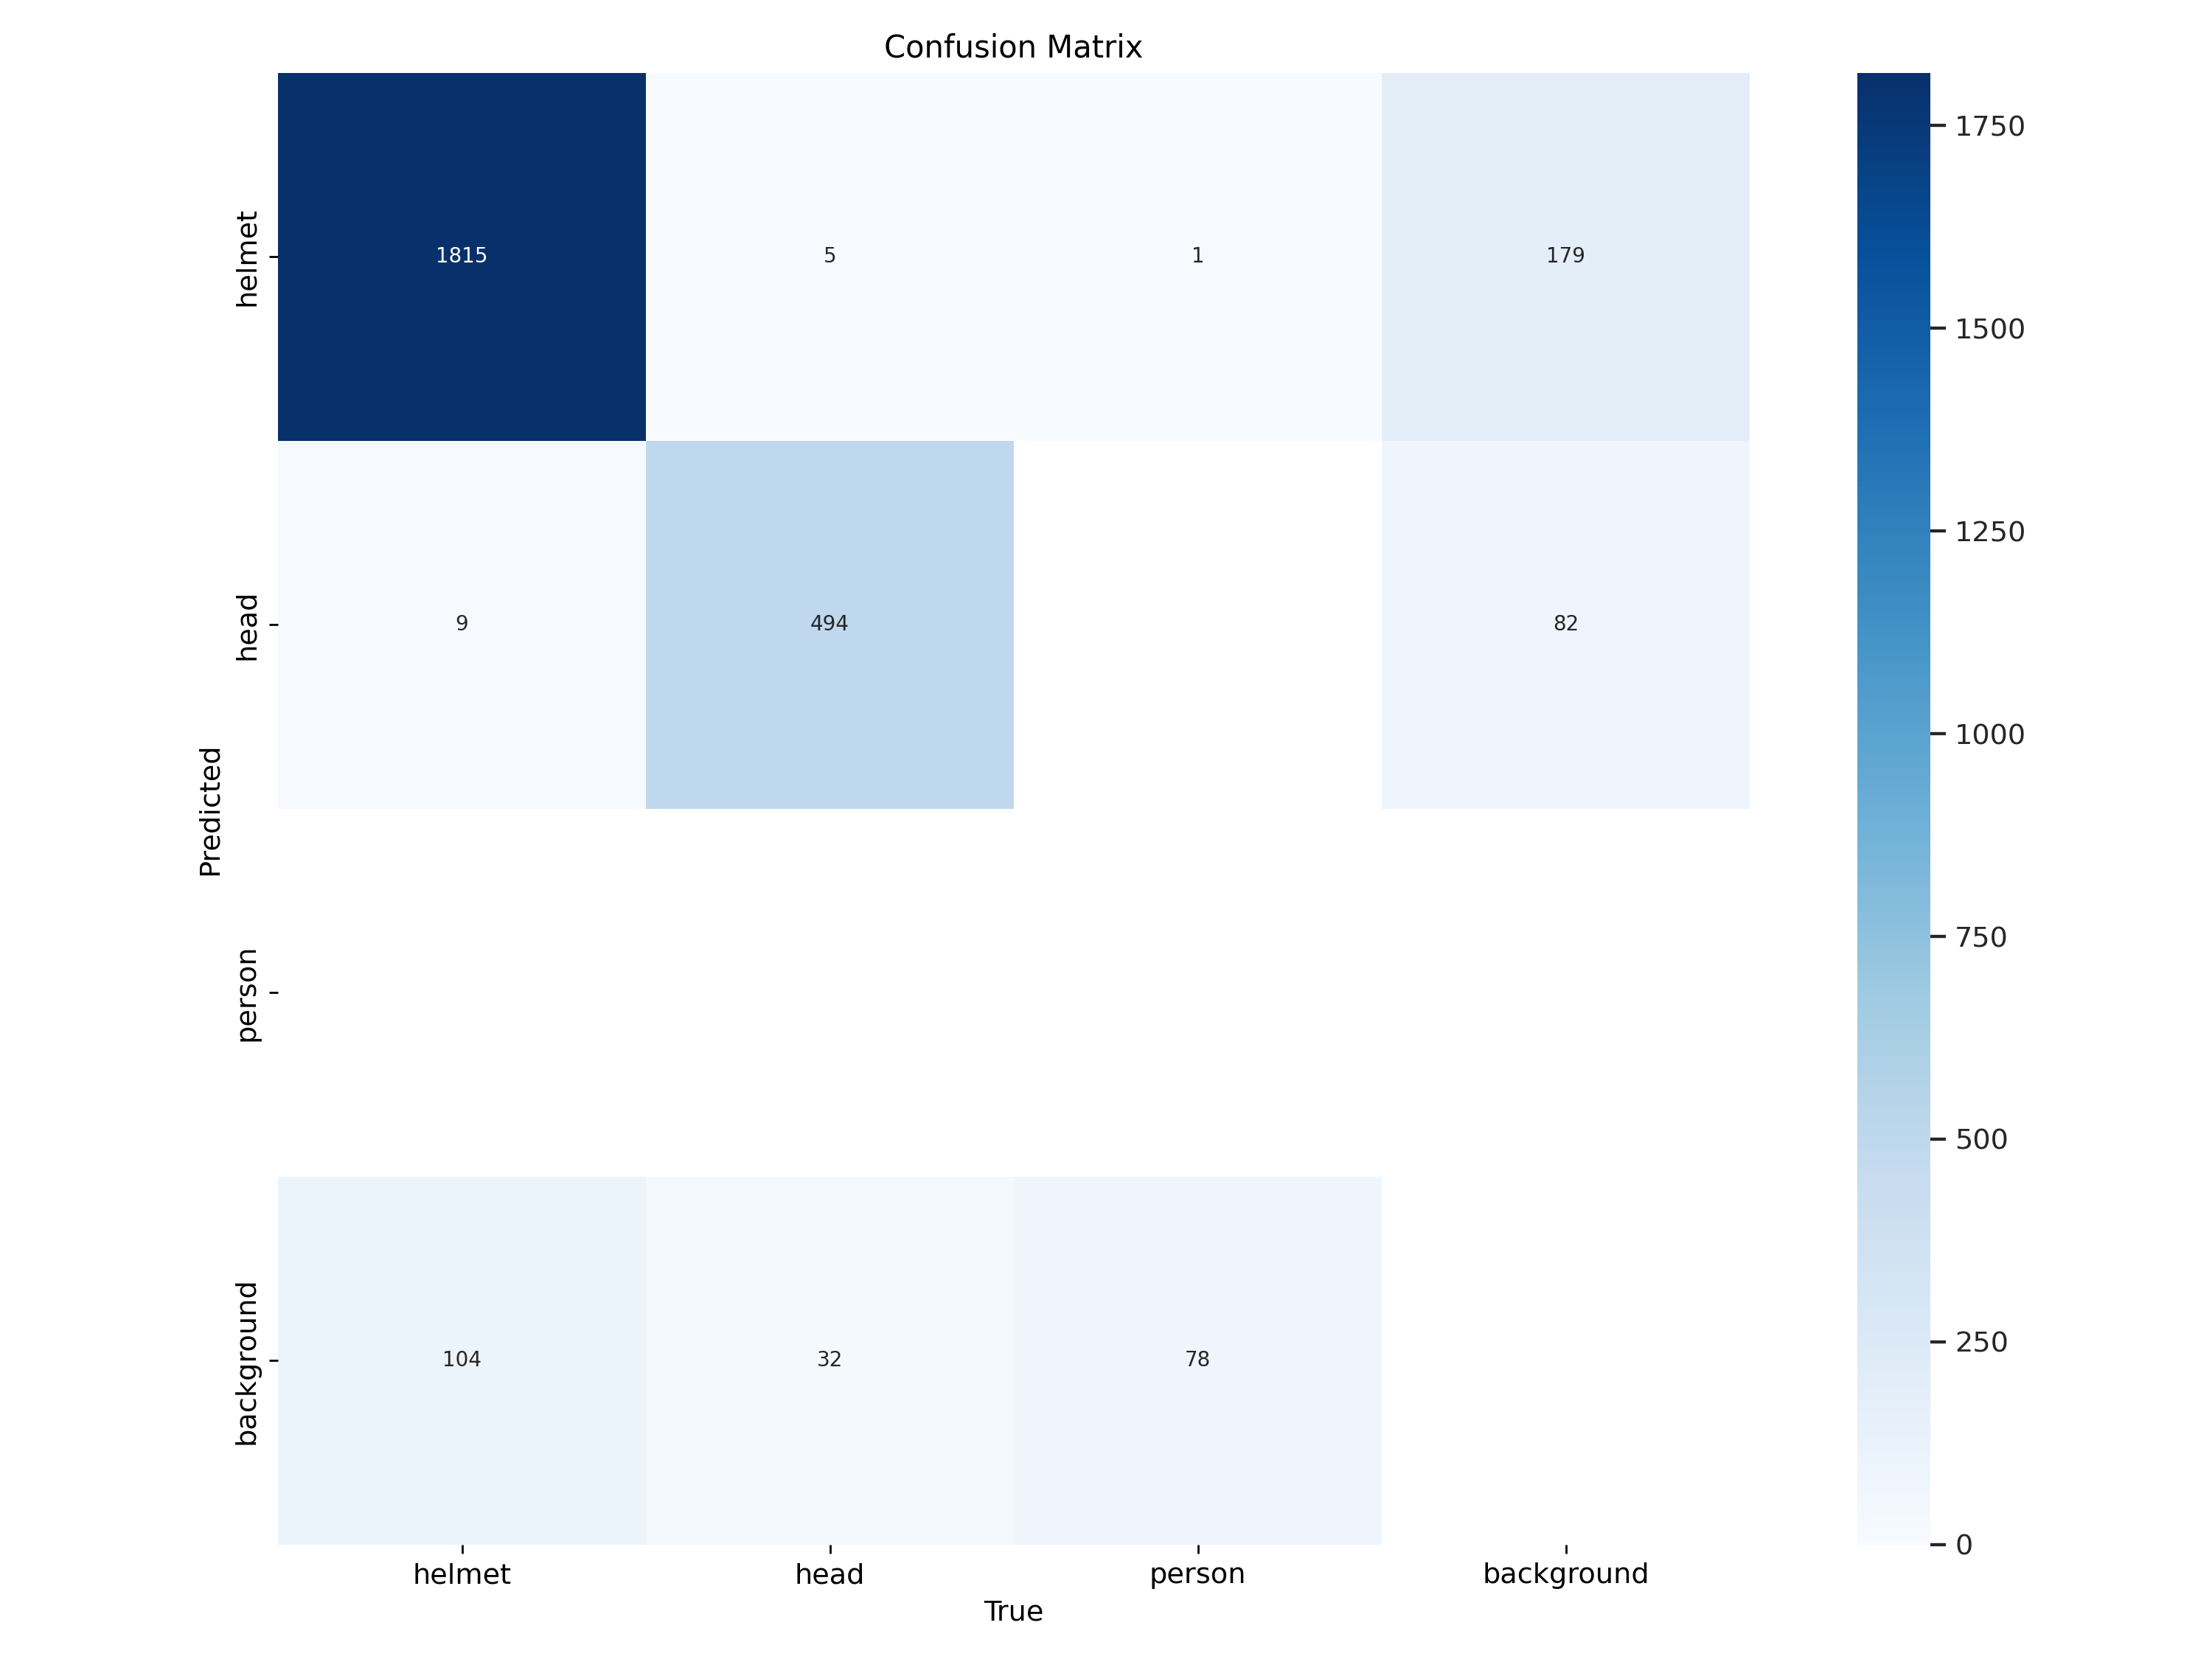

In [28]:
Image(filename='/content/runs/detect/train/confusion_matrix.png', width=800)

The Label Distribution plotted here clearly shows the **heavy imbalance** in the Dataset among Classes.

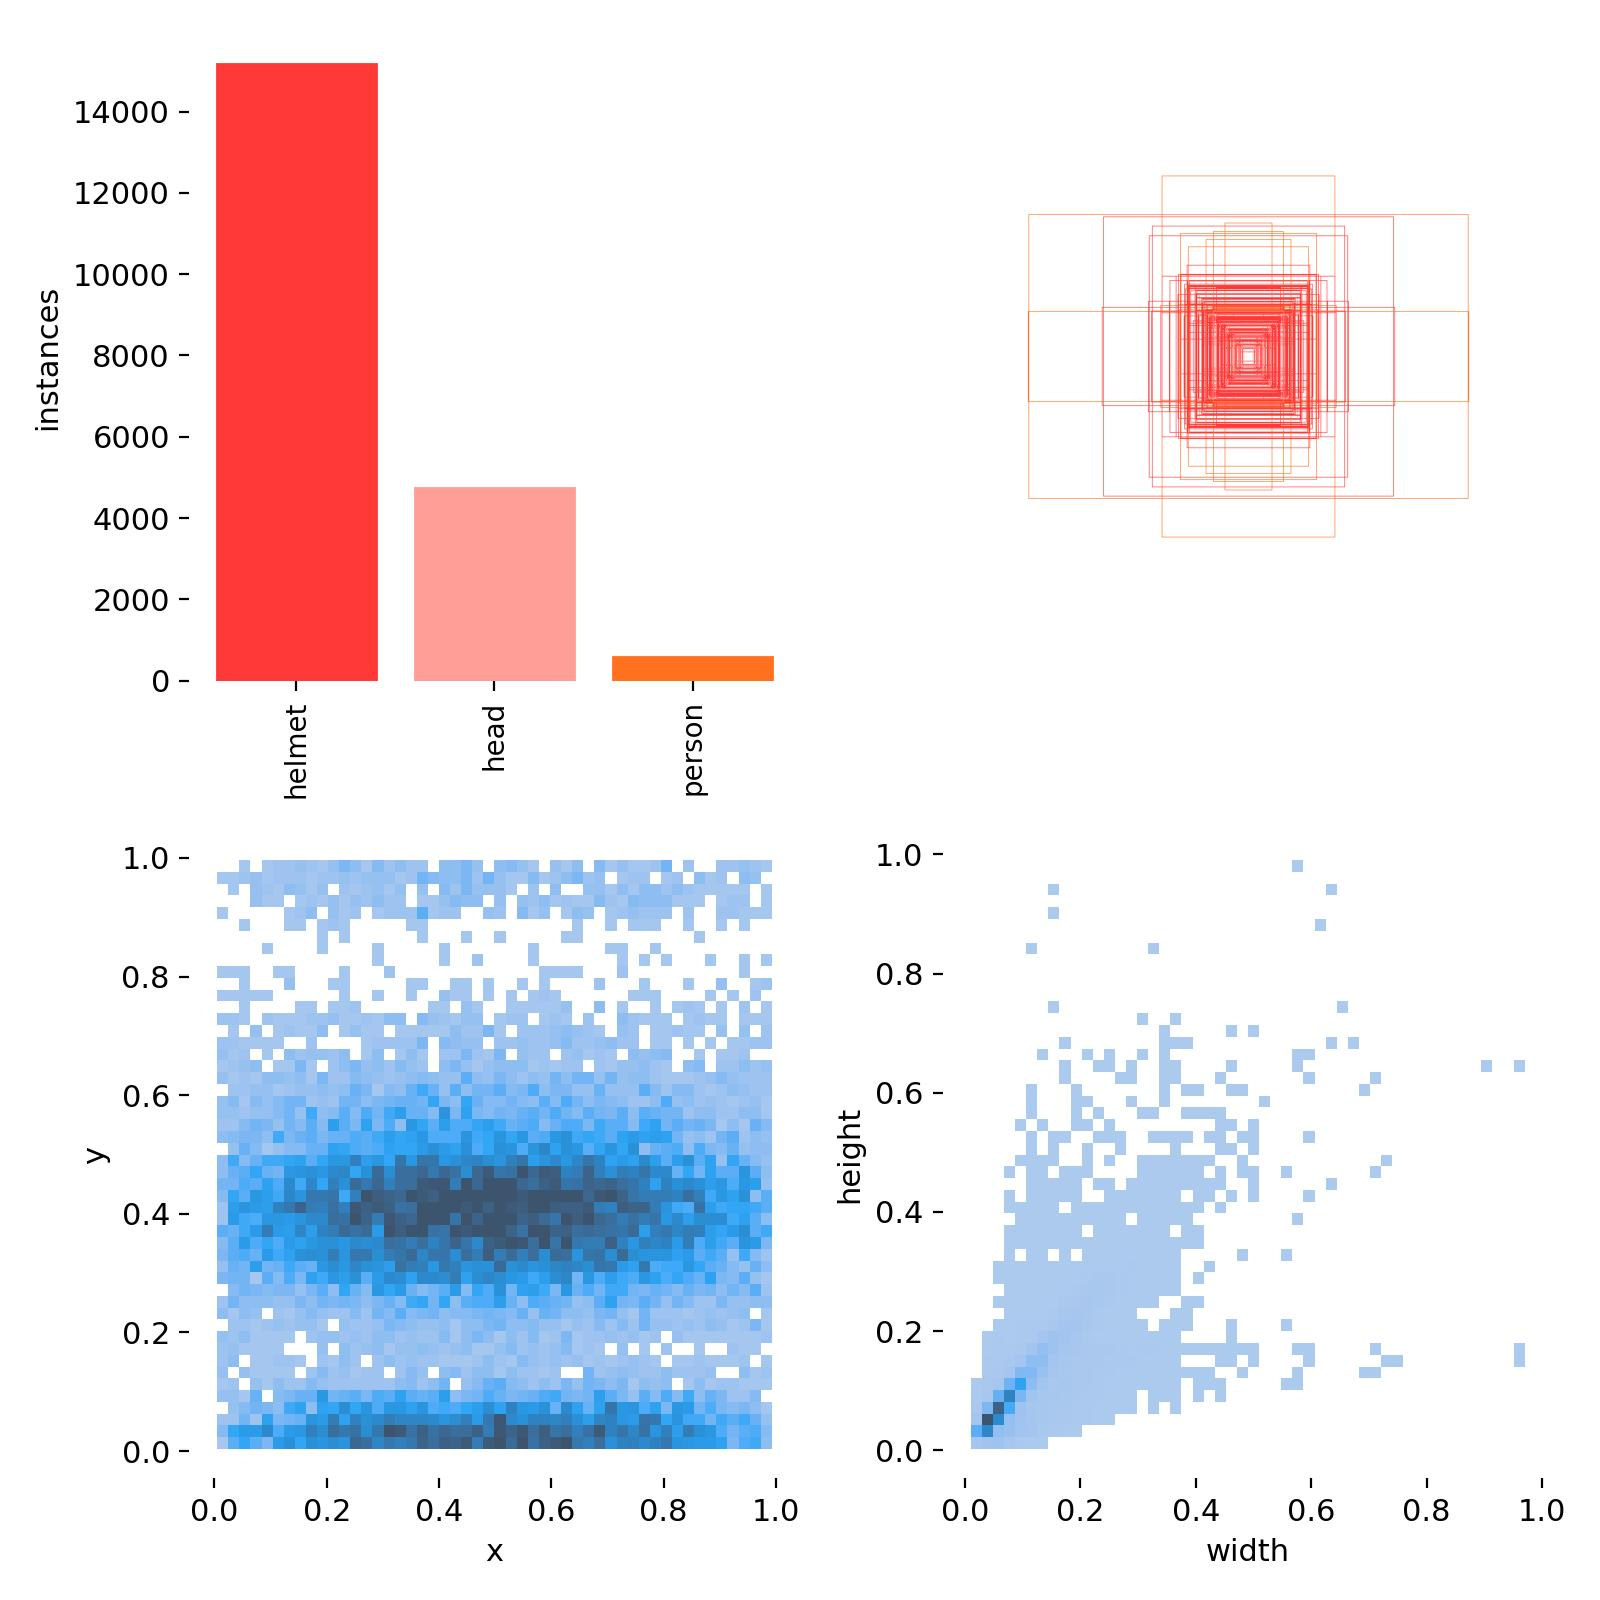

In [29]:
Image(filename='/content/runs/detect/train/labels.jpg', width=600)

In [76]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/content/runs/detect/train/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

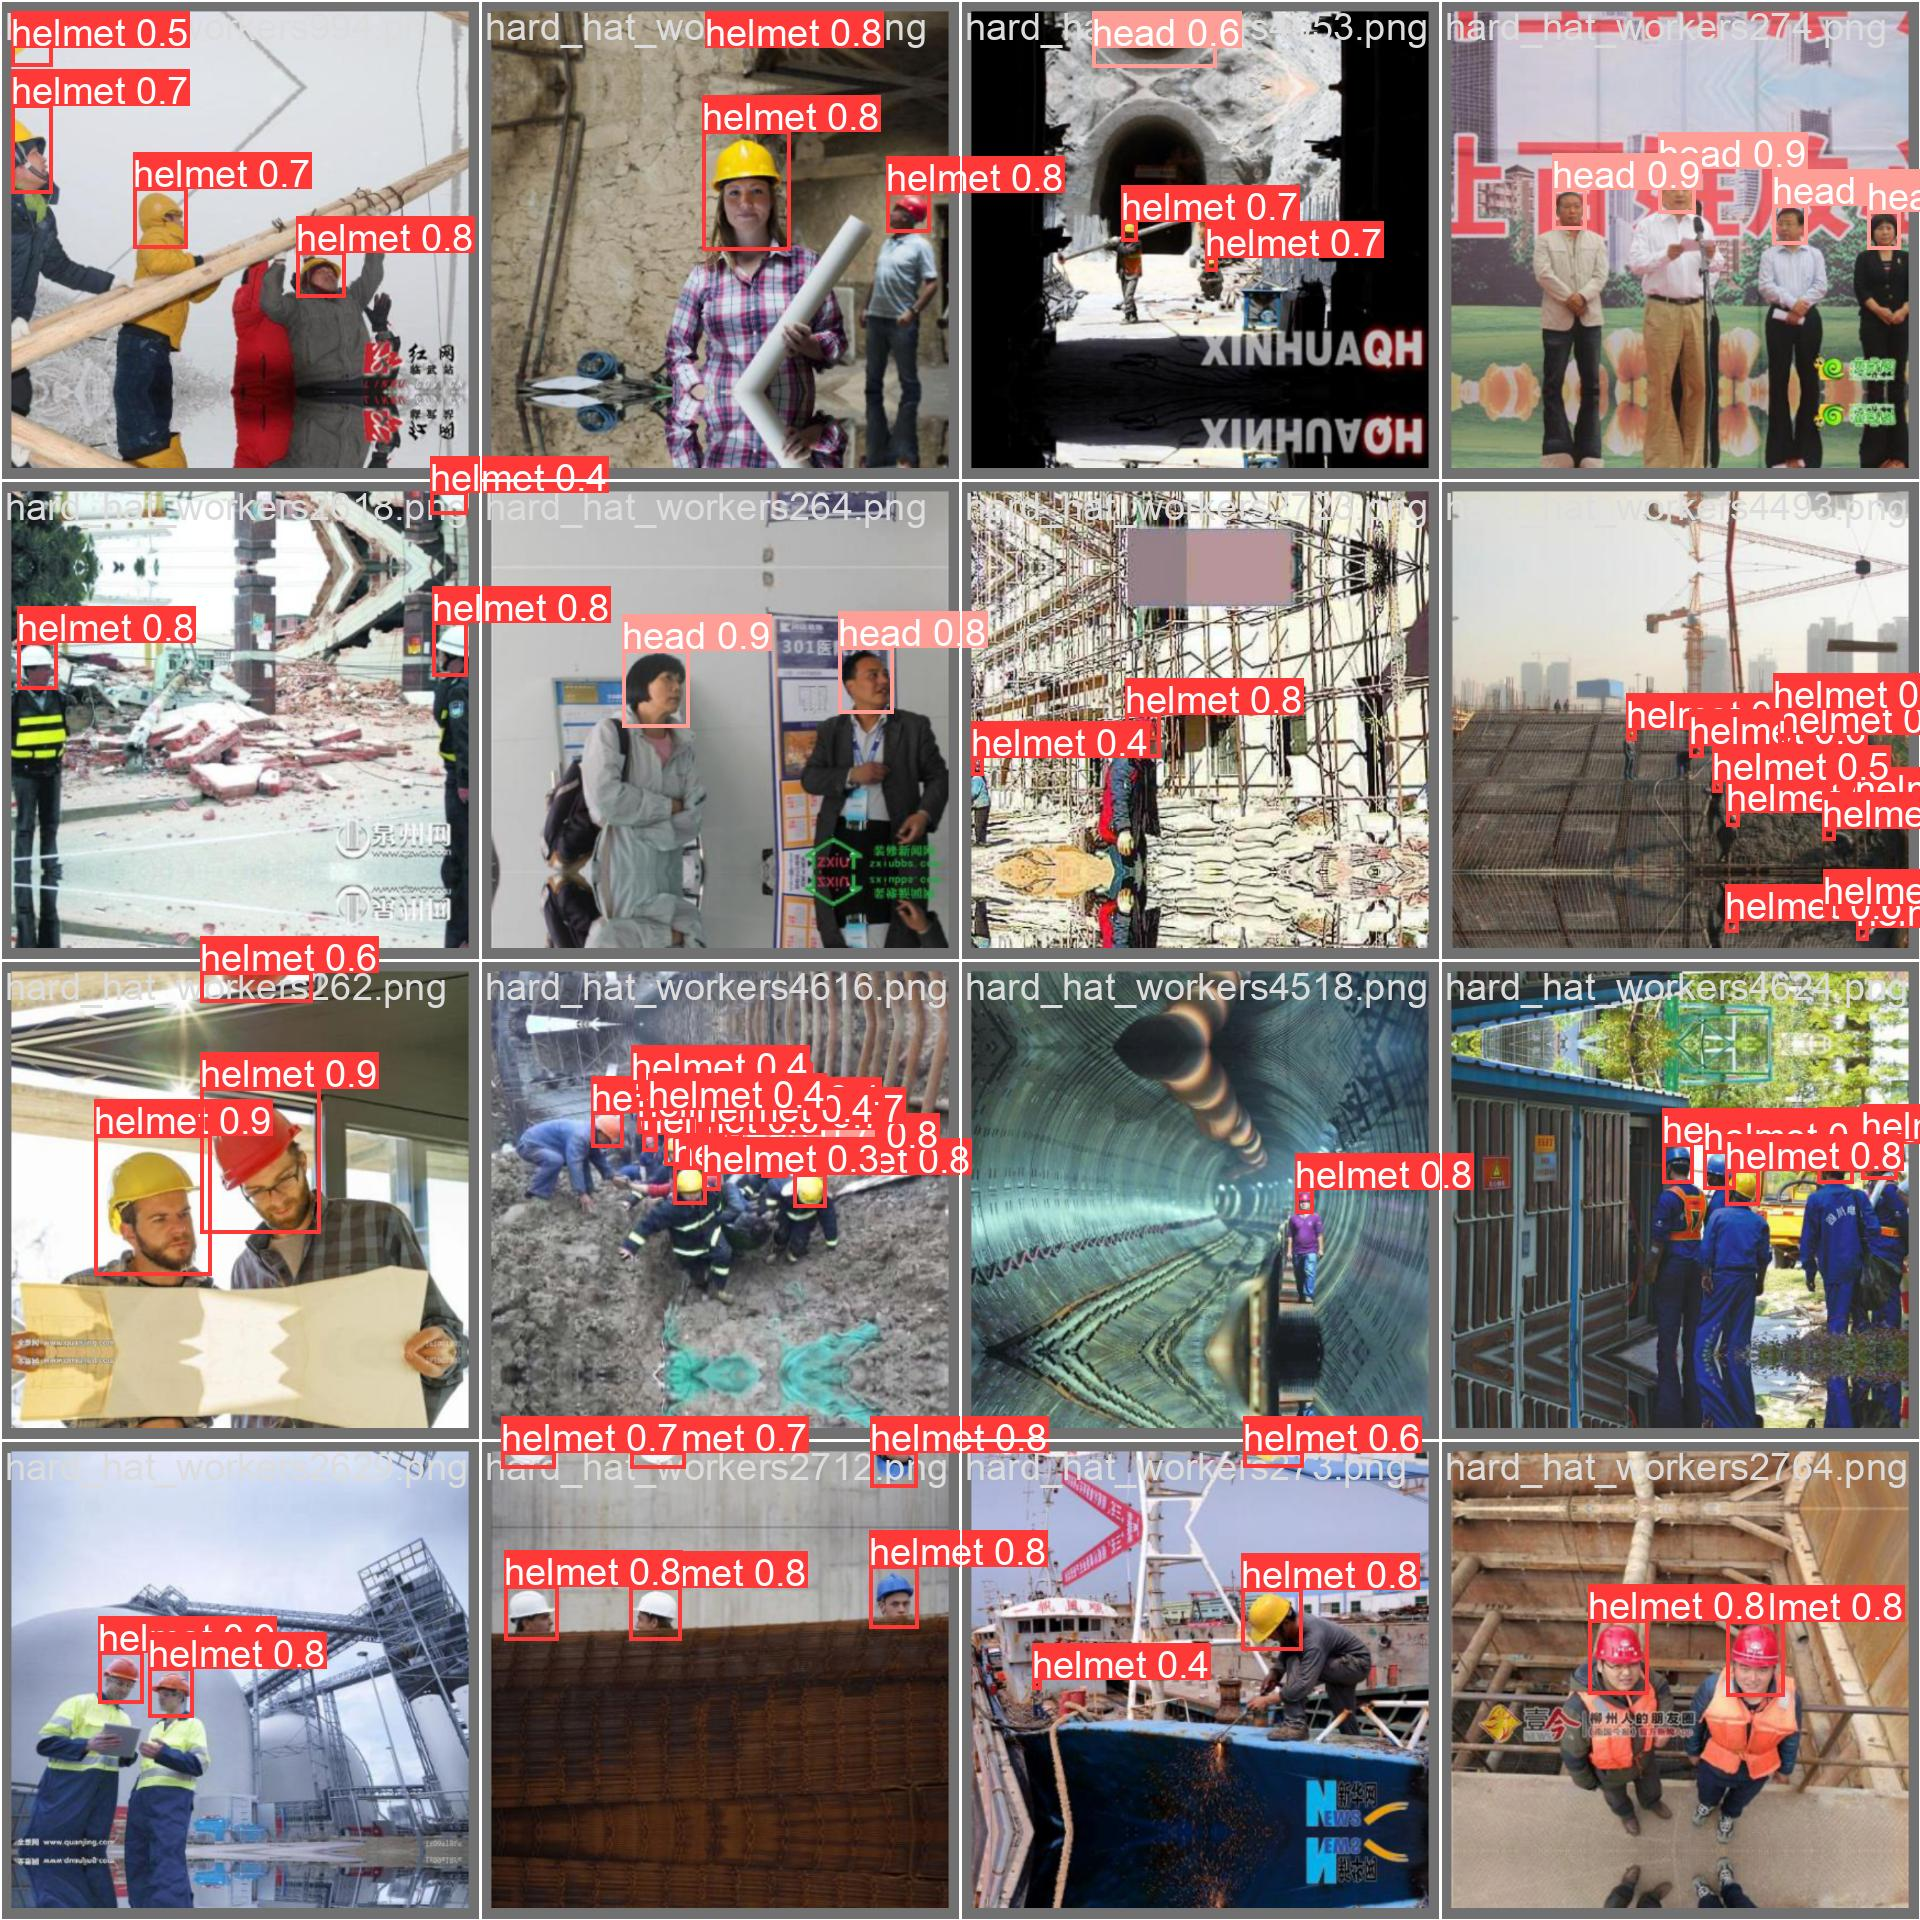

In [31]:
Image(filename='/content/runs/detect/train/val_batch0_pred.jpg', width=1000)

# These are the performance metrics on **Validation Dataset**.

In [33]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=data.yaml save_json = True

Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/drive/My Drive/helmet_dataset_YOLO/labels/val.cache... 500 images, 0 backgrounds, 0 corrupt: 100% 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 32/32 [00:21<00:00,  1.46it/s]
                   all        500       2538      0.959      0.602      0.643      0.429
                helmet        500       1928      0.962      0.901      0.969      0.646
                  head        500        531      0.916      0.904      0.939      0.631
                person        500         79          1          0     0.0217      0.011
Speed: 0.9ms preprocess, 20.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Saving runs/detect/val2/predictions.json...
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.co

In [ ]:
# Define paths
source_dir = '/content/runs/detect/val'
destination_dir = '/content/drive/My Drive/helmet_dataset_YOLO/YOLO_results'
os.makedirs(destination_dir,exist_ok = True)

# Copy files from runs/detect to Google Drive
shutil.copytree(source_dir, os.path.join(destination_dir,'val'))

# **Evaluating the Model on Test Dataset**
# By Precision & Recall Metrics

# Detection Threshold = 0.25 (Default)

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source="/content/drive/MyDrive/helmet_dataset_YOLO/images/test" save_txt=True save=True

In [ ]:
# Define paths
source_dir = '/content/runs/detect/predict'
destination_dir = '/content/drive/My Drive/helmet_dataset_YOLO/YOLO_results'
os.makedirs(destination_dir,exist_ok = True)

# Copy files from runs/detect to Google Drive
shutil.copytree(source_dir, os.path.join(destination_dir,'predict'))

In [37]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes in YOLO format.

    Parameters:
    - box1: Tuple (center_x, center_y, width, height)
    - box2: Tuple (center_x, center_y, width, height)

    Returns:
    - IoU: Intersection over Union
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_left = max(x1 - w1 / 2, x2 - w2 / 2)
    y_top = max(y1 - h1 / 2, y2 - h2 / 2)
    x_right = min(x1 + w1 / 2, x2 + w2 / 2)
    y_bottom = min(y1 + h1 / 2, y2 + h2 / 2)

    # Calculate area of intersection rectangle
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate areas of the individual bounding boxes
    area_box1 = w1 * h1
    area_box2 = w2 * h2

    # Calculate Union (area of box1 + area of box2 - intersection area)
    union_area = area_box1 + area_box2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

In [38]:
import os

def parse_yolo_label_file(lbl_src_path, img_name_txt):
    """
    Parse a YOLO label file and return a dictionary.

    Parameters:
    - lbl_src_path: Path to the directory containing YOLO label files.
    - img_name: Name of the image file (with extension).

    Returns:
    - annotations_dict: Dictionary containing parsed annotations.
    """
    annotations_dict = []

    label_file_path = os.path.join(lbl_src_path, img_name_txt)


    with open(label_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            values = line.strip().split()

            if len(values) >= 5:
                class_index = int(values[0])
                center_x, center_y, width, height = map(float, values[1:5])

                annotation = {
                    'class_index': class_index,
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                }

                annotations_dict.append(annotation)

    return annotations_dict

In [39]:
def parse_yolo_predictions_file(pred_src_path, img_name_txt):
    predictions_dict = []

    pred_file_path = os.path.join(pred_src_path, img_name_txt)

    with open(pred_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            values = line.strip().split()

            if len(values) >= 5:
                class_index = int(values[0])
                center_x, center_y, width, height = map(float, values[1:5])

                prediction = {
                    'class_index': class_index,
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                }

                predictions_dict.append(prediction)

    return predictions_dict


In [40]:
def calculate_precision_recall_per_image(targets, predictions, num_classes, iou_threshold=0.5):
    result_list = []

    for class_idx in range(num_classes):
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        # Filter targets and predictions for the current class
        targets_class = [target for target in targets if target['class_index'] == class_idx]
        predictions_class = [pred for pred in predictions if pred['class_index'] == class_idx]

        for target in targets_class:
            matched_prediction = False

            for prediction in predictions_class:
                iou = calculate_iou(
                    [target['center_x'], target['center_y'], target['width'], target['height']],
                    [prediction['center_x'], prediction['center_y'], prediction['width'], prediction['height']]
                )

                if iou >= iou_threshold:
                    matched_prediction = True
                    break

            if matched_prediction:
                true_positives += 1
            else:
                false_negatives += 1

        false_positives = len(predictions_class) - true_positives

        result_list.append([true_positives, false_positives, false_negatives])

    return result_list


In [ ]:
from tqdm import tqdm
list_final=  [[0,0,0],[0,0,0],[0,0,0]]

test_labels_path = "/content/drive/My Drive/helmet_dataset_YOLO/labels/test"


pred_labels_path ="/content/drive/MyDrive/helmet_dataset_YOLO/YOLO_results/predict/labels"
file_names = os.listdir(pred_labels_path)

classes= ['helmet','head', 'person']

num_classes=len(classes)
iou_threshold=0.5

for input_image in tqdm(file_names, total=len(file_names)):
  annotations = parse_yolo_label_file(test_labels_path, input_image)
  predictions = parse_yolo_predictions_file(pred_labels_path, input_image)
  lists= calculate_precision_recall_per_image(annotations, predictions, num_classes, iou_threshold)
  for idx,list in enumerate(lists):
    for i in range(3):
      list_final[idx][i] += list[i]

In [44]:
def calculate_precision_recall(list):
  precision_recall_dict={}
  for idx,element in enumerate(list):
    true_positives, false_positives, false_negatives = element
    precision_ = true_positives / (true_positives + false_positives + 1e-6)
    recall_ = true_positives / (true_positives + false_negatives + 1e-6)
    precision = round(precision_, 4)
    recall = round(recall_, 4)
    precision_recall_dict[f'Class {idx+1}'] = {'Precision': precision, 'Recall': recall}

  return precision_recall_dict

# saving the results and storing them in a dictionary
precision_recall_result= calculate_precision_recall(list_final)
# Print the results
print('\n')
idx=0

def caps(input_str):
    return input_str.upper()

for class_name, metrics in precision_recall_result.items():
    print(caps(classes[idx]))
    print(f"{class_name}: Precision = {metrics['Precision']:.4f}, Recall = {metrics['Recall']:.4f}")
    print()
    idx+=1



HELMET
Class 1: Precision = 0.8901, Recall = 0.9383

HEAD
Class 2: Precision = 0.8094, Recall = 0.9213

PERSON
Class 3: Precision = 0.0000, Recall = 0.0000



# **Evaluating the Model on Test Dataset by *mAP @0.5* Metric**
# Here we're using **split** argument as **'test'** for getting the Performance Metrics on the Test Dataset explicitly.(An Indirect Method)
# Bcoz there is no direct CLI or Python Command for evaluting the results on the Test Dataset.

In [45]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=data.yaml split='test' save_json= True

Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/drive/My Drive/helmet_dataset_YOLO/labels/test... 500 images, 0 backgrounds, 0 corrupt: 100% 500/500 [00:05<00:00, 93.97it/s] 
val: New cache created: /content/drive/My Drive/helmet_dataset_YOLO/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 32/32 [00:19<00:00,  1.67it/s]
                   all        500       2462      0.941      0.607      0.634      0.419
                helmet        500       1866      0.948      0.914      0.963      0.645
                  head        500        521      0.874      0.908      0.915      0.599
                person        500         75          1          0     0.0245     0.0135
Speed: 0.8ms preprocess, 20.9ms inference, 0.0ms loss, 3.0ms postprocess per image
Saving runs/detect/val3/predict

In [54]:
yolo_map = 63.4

In [ ]:
# Define paths
source_dir = '/content/runs/detect/val3'
destination_dir = '/content/drive/My Drive/helmet_dataset_YOLO/YOLO_results'
os.makedirs(destination_dir,exist_ok = True)

# Copy files from runs/detect to Google Drive
shutil.copytree(source_dir, os.path.join(destination_dir,'test_results'))

# **Taking Inference on Video Samples**
# Saving Results on Google Drive

In [ ]:
!yolo detect predict model="/content/runs/detect/train/weights/best.pt" source="/content/drive/MyDrive/helmet_dataset_YOLO/videos_infer"

In [53]:
# Define paths
src_dir = '/content/runs/detect/predict5'
files= os.listdir(src_dir)
dst_dir = '/content/drive/My Drive/helmet_dataset_YOLO/video_infer_results'
os.makedirs('/content/drive/My Drive/helmet_dataset_YOLO/video_infer_results', exist_ok = True)
for file in files:
  # Copy files from runs/detect to Google Drive
  shutil.copy(os.path.join(src_dir,file) ,dst_dir)

# Comparing Two Models: ***Faster RCNN and YOLOv8***

In [55]:
#If already Calculated once, just run only this cell afterwards, it will load the Evaluation Results stored.
import json

# Load precision-recall results from the JSON file
with open('/content/drive/My Drive/helmet_dataset/precision_recall_results_RCNN.json', 'r') as json_file:
    rcnn_results = json.load(json_file)

# Now, rcnn_results contains the data from the JSON file
print(rcnn_results)

{'Class 1': {'Precision': 0.7664, 'Recall': 0.6235}, 'Class 2': {'Precision': 0.5, 'Recall': 0.0017}, 'Class 3': {'Precision': 0.0, 'Recall': 0.0}}


In [56]:
import json

# Save to a JSON file
with open('/content/drive/My Drive/helmet_dataset_YOLO/precision_recall_results_YOLO.json', 'w') as json_file:
    json.dump(precision_recall_result, json_file)

In [57]:
#If already Calculated once, just run only this cell afterwards, it will load the Evaluation Results stored.
import json

# Load precision-recall results from the JSON file
with open('/content/drive/My Drive/helmet_dataset_YOLO/precision_recall_results_YOLO.json', 'r') as json_file:
    yolo_results = json.load(json_file)

# Now, yolo_results contains the data from the JSON file
print(yolo_results)

{'Class 1': {'Precision': 0.8901, 'Recall': 0.9383}, 'Class 2': {'Precision': 0.8094, 'Recall': 0.9213}, 'Class 3': {'Precision': 0.0, 'Recall': 0.0}}


In [59]:
def extract_metrics(results):
    precision = {class_idx: values['Precision'] for class_idx, values in results.items()}
    recall = {class_idx: values['Recall'] for class_idx, values in results.items()}
    return precision, recall

rcnn_precision, rcnn_recall = extract_metrics(rcnn_results)
yolo_precision, yolo_recall = extract_metrics(yolo_results)

In [60]:
rcnn_precision

{'Class 1': 0.7664, 'Class 2': 0.5, 'Class 3': 0.0}

In [61]:
rcnn_recall

{'Class 1': 0.6235, 'Class 2': 0.0017, 'Class 3': 0.0}

In [62]:
yolo_precision

{'Class 1': 0.8901, 'Class 2': 0.8094, 'Class 3': 0.0}

In [63]:
yolo_recall

{'Class 1': 0.9383, 'Class 2': 0.9213, 'Class 3': 0.0}

In [70]:
# Load mAP value from JSON file
with open('/content/drive/MyDrive/helmet_dataset/mAP_value_RCNN.json', 'r') as file:
    rcnn_map = json.load(file)

print(f'Value of mAP@{iou_threshold} = {rcnn_map}%')  # Prints the mAP value @0.5 IoU Threshold

Value of mAP@0.5 = 25.34%


In [72]:
print('mAP@0.5')
print(f'RCNN : {rcnn_map:.2f}%')
print(f'YOLO : {yolo_map:.2f}%')

mAP@0.5
RCNN : 25.34%
YOLO : 63.40%


# Conclusion:
# **YOLOv8**, the new State of the Art (SOTA) Model is quite accurate & fast comparative to the conventional models used for Object Detection Models, like here we used Faster R-CNN. And the results are quite astonishing.

# While the Faster R-CNN struggled a bit giving a quite low **mAP @0.5** value as **"25.34%"**, on the other hand, YOLOv8 totally outperformed the former model by giving the same **mAP @0.5** as **"63.40%"**.

# Also due to its rapid processing speed, as it takes around **10ms** on an avg. for an image prediction while the latter one takes around **142ms** for the same. Almost **15x** times faster.

# So, It easily surpasses the criteria of **24fps** for a model to be run on Video. (YOLOv8 FPS = 83FPS)